In [1]:
!pip install varname

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, cv2, shutil, random
import json
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage import io
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from requests.compat import urlparse, urlunparse, urljoin
from bs4 import BeautifulSoup
import re
import requests
from requests import Session, request, get
import urllib.request
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
from varname import nameof
from functools import reduce 
import sqlite3
import random

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import resnet, resnet_v2, ResNet50, ResNet50V2, EfficientNetB3, InceptionV3, InceptionResNetV2
from tensorboard.plugins import projector

In [5]:
def myPreprocess_image_fin(fname):
  try:
    image_string = tf.io.read_file(fname)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224,224,3)[:2]) # TARGET_SHAPE
    return image
  except:
    print(fname)

In [6]:
def visualize(anchor, positive, negative, n=3):
    """Visualize triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(3*n, 9))

    axs = fig.subplots(n, 3)
    for i in range(n):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [ ]:
def substitute(url):
    base_dir = r"/content/drive/Othercomputers/내 노트북 (2)/test_002013"
    for i in os.listdir(base_dir):
        if i == (url.split('/')[-2] + '_' + url.split('/')[-1][:-4] + '.' + url[-3:]):
            try:
                if tf.io.read_file(os.path.join(base_dir ,i)):
                    return os.path.join(base_dir ,i)
            except:
                return "0"
    return "0"

In [7]:
def create_negative(dataframe, idx): 

    rand_int = random.randint(0, len(dataframe)-1)
    if dataframe.loc[idx, "goods_id"] != dataframe.loc[rand_int, "goods_id"]:
        dataframe.loc[idx, "negative"] = dataframe.loc[rand_int, "positive"]
        
    else:
        create_negative(dataframe, idx)

Load Data

In [8]:
df_styleReview_merge = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_pure.csv", dtype=object)

In [9]:
sample_path_drive = []
sample_path_local = df_styleReview_merge.sample_path_local.to_list()
for i in sample_path_local:
  sample_path_drive_elm = "/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/sampleImg/" + i.split('\\')[-1]
  sample_path_drive.append(sample_path_drive_elm)

review_path_drive = []
for i, row in df_styleReview_merge.iterrows():
    base_dir = "/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train"
    review_path_drive_elm = os.path.join(base_dir, row["filename"])
    review_path_drive.append(review_path_drive_elm)

df_styleReview_merge["sample_path_drive"] = sample_path_drive
df_styleReview_merge["review_path_drive"] = review_path_drive

In [10]:
df_styleReview_merge

goods_id_pure index                                           filename  \
0            25868  2776  25868_0_gallery_5bc7100bc4ff6_jpg.rf.6447220e7...   
1            25868  1168  25868_0_gallery_5bcc87a2b5ce9_jpg.rf.b6559a493...   
2            25868  1281  25868_0_gallery_5e57d8c343ff9_jpg.rf.bc6e3cebc...   
3            25868  3062  25868_0_gallery_5bff80bbdad6a_jpg.rf.7201fb298...   
4            25868  1149  25868_0_gallery_5f51a6f94de0f_jpg.rf.b63152a86...   
...            ...   ...                                                ...   
5084       2930893   563  2930893_0_gallery_6390a095e1d56_jpg.rf.1a1691c...   
5085       2946308   984  2946308_0_gallery_63870cdf9a6ca_jpg.rf.aed7fd1...   
5086       2946977  2536  2946977_0_gallery_638c3022598b8_jpg.rf.9983a27...   
5087       2946977   629  2946977_0_gallery_638f4eaec5812_jpg.rf.1da588c...   
5088       2957405  2333  2957405_0_gallery_6391772381e17_jpg.rf.8e3f6a4...   

     width height xmin ymin  xmax  ymax goods_id mid_category  \
0      298    717    0    0   298   717    25868       003002   
1      368    809    0    0   368   809    25868       003002   
2      133    373    0    0   133   373    25868       003002   
3      370    583    0    0   370   583    25868       003002   
4       68    166    0    0    68   166    25868       003002   
...    ...    ...  ...  ...   ...   ...      ...          ...   
5084   181    158    0    0   181   158  2930893       018002   
5085  1252   1543    0    0  1252  1543  2946308       002021   
5086    68     63    0    0    68    63  2946977       005011   
5087   131     87    0    0   131    87  2946977       005011   
5088   190    367    0    0   190   367  2957405       003005   

                                            goods_image  \
0     https://image.msscdn.net/images/goods_img/2012...   
1     https://image.msscdn.net/images/goods_img/2012...   
2     https://image.msscdn.net/images/goods_img/2012...   
3     https://image.msscdn.net/images/goods_img/2012...   
4     https://image.msscdn.net/images/goods_img/2012...   
...                                                 ...   
5084  https://image.msscdn.net/images/goods_img/2022...   
5085  https://image.msscdn.net/images/goods_img/2022...   
5086  https://image.msscdn.net/images/goods_img/2022...   
5087  https://image.msscdn.net/images/goods_img/2022...   
5088  https://image.msscdn.net/images/goods_img/2022...   

                                      sample_path_local  \
0     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
...                                                 ...   
5084  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5085  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5086  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5087  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5088  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                      review_path_local  \
0     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4     C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
...                                                 ...   
5084  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5085  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5086  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5087  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
5088  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                      sample_path_drive  \
0     /content/drive/Othercomputers/내 노트북/12sw_proje...   
1     /content/drive/Othercomp

In [11]:
df_styleReview_merge.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_drive.csv", index=False)

002007

In [12]:
df_styleReview_merge_drive = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_merge_drive.csv", dtype=object)

In [13]:
df_styleReview_002007 = df_styleReview_merge_drive.groupby("mid_category").get_group("002007") # <-- 코드 수정
df_styleReview_002007["anchor"] = df_styleReview_002007["sample_path_drive"]
df_styleReview_002007["positive"] = df_styleReview_002007["review_path_drive"]

In [14]:
df_styleReview_002007.reset_index(inplace=True)

In [15]:
sub_anchor = df_styleReview_002007["anchor"].to_list()
sub_positive = df_styleReview_002007["positive"].to_list()

In [16]:
print(df_styleReview_002007.loc[0,:]["sample_path_drive"])
print(df_styleReview_002007.loc[0,:]["sample_path_local"])
print(df_styleReview_002007.loc[0,:]["review_path_drive"])
print(df_styleReview_002007.loc[0,:]["review_path_local"])

/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/sampleImg/20151008_260755_260755_4_500.jpg
C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\12sw_project.v4i.tensorflow\sampleImg\20151008_260755_260755_4_500.jpg
/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/260755_0_gallery_621cc34eac9c8_jpg.rf.ea19f558a8ae5ba632b0d791c8ce3c79.jpg
C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\12sw_project.v4i.tensorflow\train\260755_0_gallery_621cc34eac9c8_jpg.rf.ea19f558a8ae5ba632b0d791c8ce3c79.jpg


In [17]:
anchor_tensor = list()
for i in sub_anchor:
    k = myPreprocess_image_fin(i)
    anchor_tensor.append(k)

positive_tensor = list()
for i in sub_positive:
    k = myPreprocess_image_fin(i)
    positive_tensor.append(k)
    

image_count = len(anchor_tensor)

In [18]:
for i in range(0, len(df_styleReview_002007)):
      
  create_negative(df_styleReview_002007, i)

In [19]:
sub_negative = df_styleReview_002007["negative"].to_list()
negative_tensor = list()
for i in sub_negative:
    k = myPreprocess_image_fin(i)
    negative_tensor.append(k)
    

In [20]:
df_styleReview_002007.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_002007.csv", index=False)
df_styleReview_002007 = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_002007.csv", dtype=object)

In [21]:
df_styleReview_002007

level_0 goods_id_pure index  \
0        74        260755  1567   
1        75        260755  1661   
2        76        260755  2747   
3        77        260755   688   
4       262        624843  2944   
..      ...           ...   ...   
388    5059       2877499  2284   
389    5063       2880426  2034   
390    5064       2880426  3784   
391    5065       2884115  2570   
392    5072       2895569  2237   

                                              filename width height xmin ymin  \
0    260755_0_gallery_621cc34eac9c8_jpg.rf.ea19f558...   103    199    0    0   
1    260755_0_gallery_5c3ea5c2ab4e1_jpg.rf.ede387d0...   267    511    0    0   
2    260755_0_gallery_5a697b620178e_jpg.rf.62f66f41...   118    208    0    0   
3    260755_0_gallery_5dd040c5688a0_jpg.rf.a146c711...   248    408    0    0   
4    624843_0_gallery_5c03c1ed2b225_jpg.rf.6ae4d3cb...   332    612    0    0   
..                                                 ...   ...    ...  ...  ...   
388  2877499_0_gallery_63650e0af14cd_jpg.rf.8c96bd4...   333    524    0    0   
389  2880426_0_gallery_639002f76cd1b_jpg.rf.80e758c...   241    461    0    0   
390  2880426_0_gallery_638f212d001ac_jpg.rf.d2b7c1b...   267    447    0    0   
391  2884115_0_gallery_63760697547d7_jpg.rf.9aa1a24...   416    781    0    0   
392  2895569_0_gallery_63713080ed202_jpg.rf.8a92172...   424    811    0    0   

    xmax ymax goods_id mid_category  \
0    103  199   260755       002007   
1    267  511   260755       002007   
2    118  208   260755       002007   
3    248  408   260755       002007   
4    332  612   624843       002007   
..   ...  ...      ...          ...   
388  333  524  2877499       002007   
389  241  461  2880426       002007   
390  267  447  2880426       002007   
391  416  781  2884115       002007   
392  424  811  2895569       002007   

                                           goods_image  \
0    https://image.msscdn.net/images/goods_img/2015...   
1    https://image.msscdn.net/images/goods_img/2015...   
2    https://image.msscdn.net/images/goods_img/2015...   
3    https://image.msscdn.net/images/goods_img/2015...   
4    https://image.msscdn.net/images/goods_img/2017...   
..                                                 ...   
388  https://image.msscdn.net/images/goods_img/2022...   
389  https://image.msscdn.net/images/goods_img/2022...   
390  https://image.msscdn.net/images/goods_img/2022...   
391  https://image.msscdn.net/images/goods_img/2022...   
392  https://image.msscdn.net/images/goods_img/2022...   

                                     sample_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     review_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     sample_path_d

Training

In [42]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
TARGET_SHAPE = (224, 224, 3)
EMBEDDING_DIMENSION = 256
EPOCHS = 100

In [43]:
tf.keras.backend.clear_session()

base_model = ResNet50(weights="imagenet", input_shape=TARGET_SHAPE, include_top=False)

for layer in base_model.layers:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)

output = Dense(EMBEDDING_DIMENSION, activation="linear")(x)

embedding = Model(base_model.input, output, name="Embedding")

In [44]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = Input(name="anchor", shape=TARGET_SHAPE)
positive_input = Input(name="positive", shape=TARGET_SHAPE)
negative_input = Input(name="negative", shape=TARGET_SHAPE)

distances = DistanceLayer()(embedding(resnet.preprocess_input(anchor_input)), embedding(resnet.preprocess_input(positive_input)), embedding(resnet.preprocess_input(negative_input)))

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [45]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

빼고 다시 ..

In [ ]:
# df_photoReview_001_selected_apn.drop([369, 2017, 4508, 5157, 6011, 6573, 6697, 6727, 6945, 8840,3189, 3271, \
#                                       3290, 3376, 3385, 3431, 3475, 3552, 3828, 3871, 3941],axis=0, inplace=True)

In [ ]:
# df_photoReview_001_selected_apn_001001 = df_photoReview_001_selected_apn.groupby("mid_category").get_group("001001")

In [ ]:
# sub_anchor = df_photoReview_001_selected_apn_001001.image_path_sample_drive.to_list()
# sub_positive = df_photoReview_001_selected_apn_001001.image_path_review_drive.to_list()
# sub_negative = df_photoReview_001_selected_apn_001001.image_path_negative_drive.to_list()

In [ ]:
# anchor_tensor = list()
# for i in sub_anchor:
#     k = myPreprocess_image_fin(i)
#     anchor_tensor.append(k)

# positive_tensor = list()
# for i in sub_positive:
#     k = myPreprocess_image_fin(i)
#     positive_tensor.append(k)
    
# negative_tensor = list()    
# for i in sub_negative:
#     k = myPreprocess_image_fin(i)
#     negative_tensor.append(k)

# image_count = len(anchor_tensor)

In [46]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_tensor)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_tensor)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_tensor)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
# dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [47]:
dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None))>

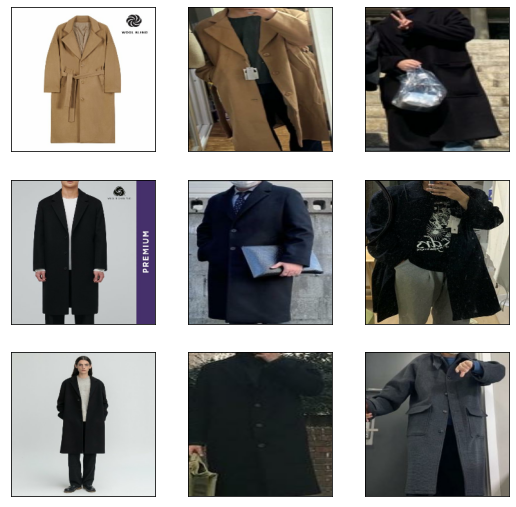

In [48]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [49]:
callbacks = [EarlyStopping(monitor='val_loss', mode='auto', patience=7, restore_best_weights=True)]

In [50]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), metrics=['accuracy'])
history = siamese_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.6858

5/5 [==============================] - 17s 1s/step - loss: 0.6858 - val_loss: 0.4695
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.4855

5/5 [==============================] - 2s 421ms/step - loss: 0.4855 - val_loss: 0.4117
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.4221

5/5 [==============================] - 2s 423ms/step - loss: 0.4221 - val_loss: 0.3909
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.3773

5/5 [==============================] - 2s 422ms/step - loss: 0.3773 - val_loss: 0.3470
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.3263

5/5 [==============================] - 2s 419ms/step - loss: 0.3263 - val_loss: 0.2697
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.3040

5/5 [==============================] - 2s 422ms/step - loss: 0.3040 - val_loss: 0.1686
Epoch 7/100
5/5 [==============================] - ETA: 0s - loss: 0.2058

5/5 [==============================] - 2s 419ms/step - loss: 0.2058 - val_loss: 0.1291
Epoch 8/100
5/5 [==============================] - ETA: 0s - loss: 0.1797

5/5 [==============================] - 2s 370ms/step - loss: 0.1797 - val_loss: 0.1794
Epoch 9/100
5/5 [==============================] - ETA: 0s - loss: 0.1744

5/5 [==============================] - 2s 422ms/step - loss: 0.1744 - val_loss: 0.1200
Epoch 10/100
5/5 [==============================] - ETA: 0s - loss: 0.1366

5/5 [==============================] - 2s 422ms/step - loss: 0.1366 - val_loss: 0.0688
Epoch 11/100
5/5 [==============================] - ETA: 0s - loss: 0.1090

5/5 [==============================] - 2s 370ms/step - loss: 0.1090 - val_loss: 0.0820
Epoch 12/100
5/5 [==============================] - ETA: 0s - loss: 0.0930

5/5 [==============================] - 2s 370ms/step - loss: 0.0930 - val_loss: 0.0972
Epoch 13/100
5/5 [==============================] - ETA: 0s - loss: 0.1103

5/5 [==============================] - 2s 370ms/step - loss: 0.1103 - val_loss: 0.0865
Epoch 14/100
5/5 [==============================] - ETA: 0s - loss: 0.0858

5/5 [==============================] - 2s 371ms/step - loss: 0.0858 - val_loss: 0.0924
Epoch 15/100
5/5 [==============================] - ETA: 0s - loss: 0.0852

5/5 [==============================] - 2s 426ms/step - loss: 0.0852 - val_loss: 0.0329
Epoch 16/100
5/5 [==============================] - ETA: 0s - loss: 0.0436

5/5 [==============================] - 2s 420ms/step - loss: 0.0436 - val_loss: 0.0267
Epoch 17/100
5/5 [==============================] - ETA: 0s - loss: 0.0430

5/5 [==============================] - 2s 422ms/step - loss: 0.0430 - val_loss: 0.0216
Epoch 18/100
5/5 [==============================] - ETA: 0s - loss: 0.0354

5/5 [==============================] - 2s 420ms/step - loss: 0.0354 - val_loss: 0.0210
Epoch 19/100
5/5 [==============================] - ETA: 0s - loss: 0.0294

5/5 [==============================] - 2s 370ms/step - loss: 0.0294 - val_loss: 0.0446
Epoch 20/100
5/5 [==============================] - ETA: 0s - loss: 0.0424

5/5 [==============================] - 2s 370ms/step - loss: 0.0424 - val_loss: 0.0307
Epoch 21/100
5/5 [==============================] - ETA: 0s - loss: 0.0219

5/5 [==============================] - 2s 421ms/step - loss: 0.0219 - val_loss: 0.0157
Epoch 22/100
2/5 [===========>..................] - ETA: 1s - loss: 0.0183

KeyboardInterrupt: ignored

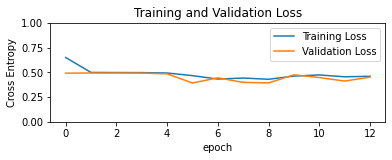

In [51]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(resnet.preprocess_input(anchor)), embedding(resnet.preprocess_input(positive)), embedding(resnet.preprocess_input(negative)),)

In [53]:
anchors, positives, negatives = sample
for i in range(len(anchor_embedding)):
    anchor, positive, negative = anchors[i], positives[i], negatives[i]
    positive_distance = np.linalg.norm(anchor_embedding[i] - positive_embedding[i], ord=2)*1e4
    negative_distance = np.linalg.norm(anchor_embedding[i] - negative_embedding[i], ord=2)*1e4
    positive_distance, negative_distance = round(positive_distance)/1e4, round(negative_distance)/1e4
    plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(anchor)
    plt.axis("off")
    plt.title("Anchor")
    plt.subplot(132)
    plt.imshow(positive)
    plt.axis("off")
    plt.title(f"Anchor to Positive Distance: {positive_distance}")
    plt.subplot(133)
    plt.imshow(negative)
    plt.axis("off")
    plt.title(f"Anchor to Negative Distance: {negative_distance}")
    plt.show()        

Output hidden; open in https://colab.research.google.com to view.

In [54]:
embedding.save("Midcateg_002007_1216.h5")

In [55]:
!cp Midcateg_002007_1216.h5 /content/drive/MyDrive/3rd_project/SiameseModels

Inference


In [56]:
TARGET_SHAPE = (224,224,3)
def preprocess_image(filename: str):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    
    Args:
        filename: Absolute / Relative file path for the image
    
    Returns:
        Preprocessed inputs of type tensorflow.Tensor for Embedding Generation 
    """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE[:2])
    image = resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0)


def generate_embedding(dataframe, embedding_generator):
    """
    Use the specified dataframe and Embeddings model to 
    calculate embeddings for all records in the dataframe
    
    Args:
        dataframe: Dataframe to get records for Embedding Generation
        embedding_genrator: Tensorflow Model to generate embeddings
    
    Returns:
        Dataframe with embeddings for each record.
    """
    embeddings_review = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["review_path_drive"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_review.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_review"] = embeddings_review
    embeddings_sample = list()
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        filename = row["sample_path_drive"]
        image = preprocess_image(filename)
        embedding = embedding_generator(image)
        embeddings_sample.append(embedding[0].numpy().astype(np.float32).tolist())
    dataframe["embedding_sample"] = embeddings_sample
    return dataframe

In [57]:
Midclass002007 = load_model("/content/drive/MyDrive/3rd_project/SiameseModels/Midcateg_002007_1216.h5", compile=False)

In [58]:
df_styleReview_002007 = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_002007.csv", dtype=object)
df_styleReview_002007

level_0 goods_id_pure index  \
0        74        260755  1567   
1        75        260755  1661   
2        76        260755  2747   
3        77        260755   688   
4       262        624843  2944   
..      ...           ...   ...   
388    5059       2877499  2284   
389    5063       2880426  2034   
390    5064       2880426  3784   
391    5065       2884115  2570   
392    5072       2895569  2237   

                                              filename width height xmin ymin  \
0    260755_0_gallery_621cc34eac9c8_jpg.rf.ea19f558...   103    199    0    0   
1    260755_0_gallery_5c3ea5c2ab4e1_jpg.rf.ede387d0...   267    511    0    0   
2    260755_0_gallery_5a697b620178e_jpg.rf.62f66f41...   118    208    0    0   
3    260755_0_gallery_5dd040c5688a0_jpg.rf.a146c711...   248    408    0    0   
4    624843_0_gallery_5c03c1ed2b225_jpg.rf.6ae4d3cb...   332    612    0    0   
..                                                 ...   ...    ...  ...  ...   
388  2877499_0_gallery_63650e0af14cd_jpg.rf.8c96bd4...   333    524    0    0   
389  2880426_0_gallery_639002f76cd1b_jpg.rf.80e758c...   241    461    0    0   
390  2880426_0_gallery_638f212d001ac_jpg.rf.d2b7c1b...   267    447    0    0   
391  2884115_0_gallery_63760697547d7_jpg.rf.9aa1a24...   416    781    0    0   
392  2895569_0_gallery_63713080ed202_jpg.rf.8a92172...   424    811    0    0   

    xmax ymax goods_id mid_category  \
0    103  199   260755       002007   
1    267  511   260755       002007   
2    118  208   260755       002007   
3    248  408   260755       002007   
4    332  612   624843       002007   
..   ...  ...      ...          ...   
388  333  524  2877499       002007   
389  241  461  2880426       002007   
390  267  447  2880426       002007   
391  416  781  2884115       002007   
392  424  811  2895569       002007   

                                           goods_image  \
0    https://image.msscdn.net/images/goods_img/2015...   
1    https://image.msscdn.net/images/goods_img/2015...   
2    https://image.msscdn.net/images/goods_img/2015...   
3    https://image.msscdn.net/images/goods_img/2015...   
4    https://image.msscdn.net/images/goods_img/2017...   
..                                                 ...   
388  https://image.msscdn.net/images/goods_img/2022...   
389  https://image.msscdn.net/images/goods_img/2022...   
390  https://image.msscdn.net/images/goods_img/2022...   
391  https://image.msscdn.net/images/goods_img/2022...   
392  https://image.msscdn.net/images/goods_img/2022...   

                                     sample_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     review_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     sample_path_d

In [59]:
df_styleReview_002007_sim = generate_embedding(df_styleReview_002007, Midclass002007)
df_styleReview_002007_sim.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_002007_sim.csv", index=False)
df_styleReview_002007_sim = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_002007_sim.csv", dtype=object)

100%|██████████| 393/393 [00:28<00:00, 13.64it/s]


In [61]:
df_styleReview_002007_sim

level_0 goods_id_pure index  \
0        74        260755  1567   
1        75        260755  1661   
2        76        260755  2747   
3        77        260755   688   
4       262        624843  2944   
..      ...           ...   ...   
388    5059       2877499  2284   
389    5063       2880426  2034   
390    5064       2880426  3784   
391    5065       2884115  2570   
392    5072       2895569  2237   

                                              filename width height xmin ymin  \
0    260755_0_gallery_621cc34eac9c8_jpg.rf.ea19f558...   103    199    0    0   
1    260755_0_gallery_5c3ea5c2ab4e1_jpg.rf.ede387d0...   267    511    0    0   
2    260755_0_gallery_5a697b620178e_jpg.rf.62f66f41...   118    208    0    0   
3    260755_0_gallery_5dd040c5688a0_jpg.rf.a146c711...   248    408    0    0   
4    624843_0_gallery_5c03c1ed2b225_jpg.rf.6ae4d3cb...   332    612    0    0   
..                                                 ...   ...    ...  ...  ...   
388  2877499_0_gallery_63650e0af14cd_jpg.rf.8c96bd4...   333    524    0    0   
389  2880426_0_gallery_639002f76cd1b_jpg.rf.80e758c...   241    461    0    0   
390  2880426_0_gallery_638f212d001ac_jpg.rf.d2b7c1b...   267    447    0    0   
391  2884115_0_gallery_63760697547d7_jpg.rf.9aa1a24...   416    781    0    0   
392  2895569_0_gallery_63713080ed202_jpg.rf.8a92172...   424    811    0    0   

    xmax ymax  ...                                        goods_image  \
0    103  199  ...  https://image.msscdn.net/images/goods_img/2015...   
1    267  511  ...  https://image.msscdn.net/images/goods_img/2015...   
2    118  208  ...  https://image.msscdn.net/images/goods_img/2015...   
3    248  408  ...  https://image.msscdn.net/images/goods_img/2015...   
4    332  612  ...  https://image.msscdn.net/images/goods_img/2017...   
..   ...  ...  ...                                                ...   
388  333  524  ...  https://image.msscdn.net/images/goods_img/2022...   
389  241  461  ...  https://image.msscdn.net/images/goods_img/2022...   
390  267  447  ...  https://image.msscdn.net/images/goods_img/2022...   
391  416  781  ...  https://image.msscdn.net/images/goods_img/2022...   
392  424  811  ...  https://image.msscdn.net/images/goods_img/2022...   

                                     sample_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     review_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     sample_path_drive  \
0    /content/drive/Othercomputers/내 노트북/12sw_proje...   
1    /content/drive/Othercomputers/내 노트북/12sw_proje...   
2    /content/drive/Othercomputers/내 노트북/12sw_proje...   
3    /content/drive/Othercomputers/내 노트북/12sw_proje...   
4    /content/drive/Othercomputers/내 노트북/12sw_pro

임의의 행의 리리

100%|██████████| 393/393 [00:00<00:00, 917.39it/s]


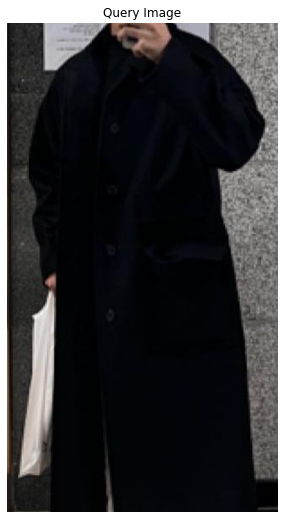

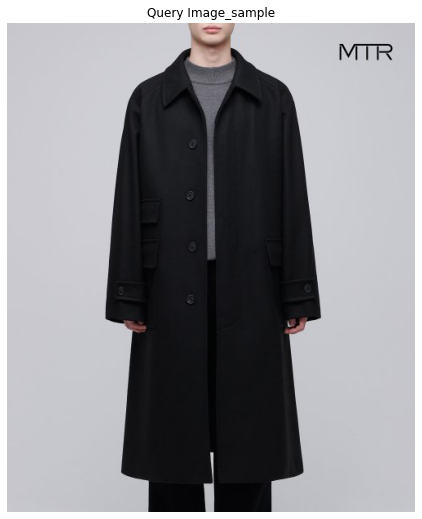

2682035


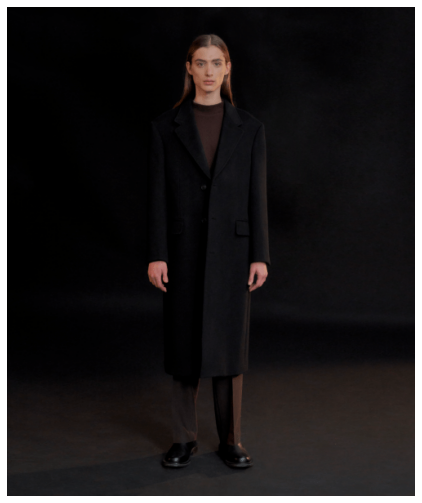

유사도 :  1.0293090343475342
2139468
Shop Now @  https://musinsa.com/app/goods/2139468


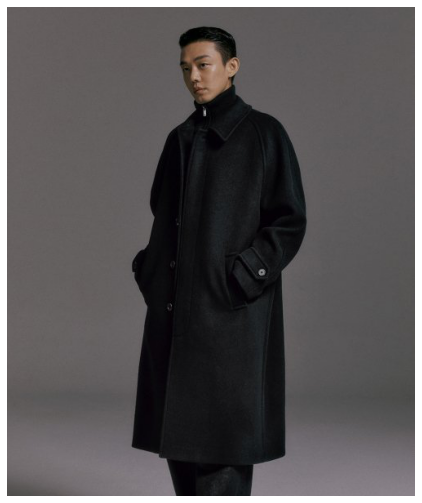

유사도 :  1.1806896924972534
2116411
Shop Now @  https://musinsa.com/app/goods/2116411


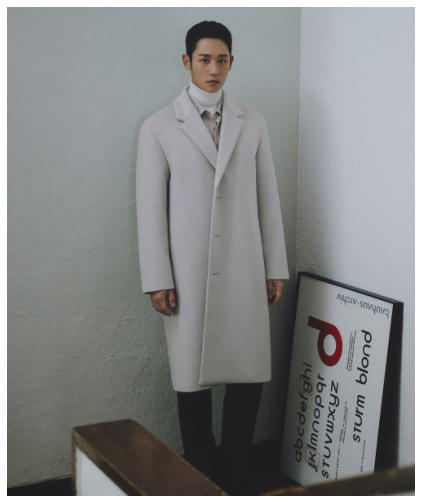

유사도 :  1.2286447286605835
2140792
Shop Now @  https://musinsa.com/app/goods/2140792


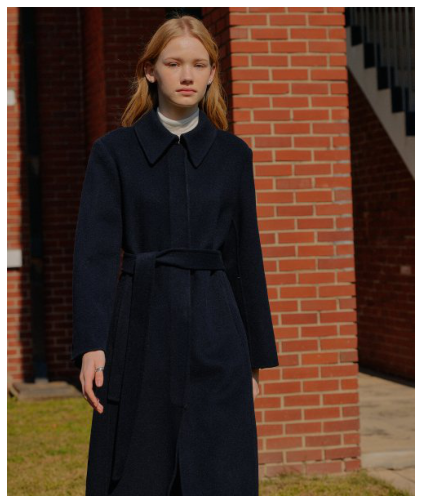

유사도 :  1.2916666269302368
2221508
Shop Now @  https://musinsa.com/app/goods/2221508


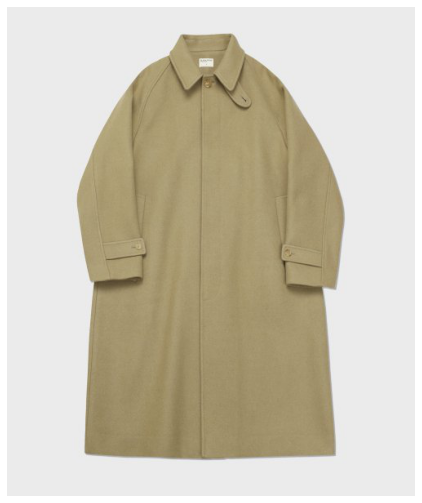

유사도 :  1.3300590515136719
2158512
Shop Now @  https://musinsa.com/app/goods/2158512


In [62]:
 tqdm.pandas()
query_row = df_styleReview_002007_sim.iloc[random.randint(0,df_styleReview_002007_sim.shape[0])] 
query_embedding = query_row.embedding_review
a = query_row["goods_id_pure"] 
b = query_row.review_path_drive
c = query_row.sample_path_drive
df_styleReview_002007_sim['distance_samImg_queryRev'] = df_styleReview_002007_sim['embedding_sample'].progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(query_embedding), dtype=np.float32)))
df_styleReview_002007_sim = df_styleReview_002007_sim.sort_values(by='distance_samImg_queryRev').reset_index(drop=True)
plt.figure(figsize=(16,9))
plt.imshow(io.imread(b))
plt.title("Query Image")
plt.axis("off");plt.show()
plt.figure(figsize=(16,9))
plt.imshow(io.imread(c))
plt.title("Query Image_sample")
plt.axis("off");plt.show()
print(a)
print(254*"=")
print(254*"=")
j = 0
for i, row in df_styleReview_002007_sim.drop_duplicates("goods_id_pure",inplace=False).iloc[:5, :].iterrows():
    j += 1
    plt.figure(figsize=(16,9))
    image = io.imread(row["sample_path_drive"])
    plt.imshow(image);plt.axis("off")
    plt.show()
    print("유사도 : ", row["distance_samImg_queryRev"])
    print(row["goods_id_pure"])
    if a == row["goods_id_pure"] :
      print(j, "번 째 일치")
    print("Shop Now @ ", ("https://musinsa.com/app/goods/" + row["goods_id_pure"]))


In [63]:
df_styleReview_002007_sim = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_002007_sim.csv", dtype=object)
df_styleReview_002007_sim 

level_0 goods_id_pure index  \
0        74        260755  1567   
1        75        260755  1661   
2        76        260755  2747   
3        77        260755   688   
4       262        624843  2944   
..      ...           ...   ...   
388    5059       2877499  2284   
389    5063       2880426  2034   
390    5064       2880426  3784   
391    5065       2884115  2570   
392    5072       2895569  2237   

                                              filename width height xmin ymin  \
0    260755_0_gallery_621cc34eac9c8_jpg.rf.ea19f558...   103    199    0    0   
1    260755_0_gallery_5c3ea5c2ab4e1_jpg.rf.ede387d0...   267    511    0    0   
2    260755_0_gallery_5a697b620178e_jpg.rf.62f66f41...   118    208    0    0   
3    260755_0_gallery_5dd040c5688a0_jpg.rf.a146c711...   248    408    0    0   
4    624843_0_gallery_5c03c1ed2b225_jpg.rf.6ae4d3cb...   332    612    0    0   
..                                                 ...   ...    ...  ...  ...   
388  2877499_0_gallery_63650e0af14cd_jpg.rf.8c96bd4...   333    524    0    0   
389  2880426_0_gallery_639002f76cd1b_jpg.rf.80e758c...   241    461    0    0   
390  2880426_0_gallery_638f212d001ac_jpg.rf.d2b7c1b...   267    447    0    0   
391  2884115_0_gallery_63760697547d7_jpg.rf.9aa1a24...   416    781    0    0   
392  2895569_0_gallery_63713080ed202_jpg.rf.8a92172...   424    811    0    0   

    xmax ymax  ...                                        goods_image  \
0    103  199  ...  https://image.msscdn.net/images/goods_img/2015...   
1    267  511  ...  https://image.msscdn.net/images/goods_img/2015...   
2    118  208  ...  https://image.msscdn.net/images/goods_img/2015...   
3    248  408  ...  https://image.msscdn.net/images/goods_img/2015...   
4    332  612  ...  https://image.msscdn.net/images/goods_img/2017...   
..   ...  ...  ...                                                ...   
388  333  524  ...  https://image.msscdn.net/images/goods_img/2022...   
389  241  461  ...  https://image.msscdn.net/images/goods_img/2022...   
390  267  447  ...  https://image.msscdn.net/images/goods_img/2022...   
391  416  781  ...  https://image.msscdn.net/images/goods_img/2022...   
392  424  811  ...  https://image.msscdn.net/images/goods_img/2022...   

                                     sample_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     review_path_local  \
0    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
1    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
2    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
3    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
4    C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
..                                                 ...   
388  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
389  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
390  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
391  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   
392  C:\Users\panda\2022 SWA 아카데미\3차 프로젝트\cropped\1...   

                                     sample_path_drive  \
0    /content/drive/Othercomputers/내 노트북/12sw_proje...   
1    /content/drive/Othercomputers/내 노트북/12sw_proje...   
2    /content/drive/Othercomputers/내 노트북/12sw_proje...   
3    /content/drive/Othercomputers/내 노트북/12sw_proje...   
4    /content/drive/Othercomputers/내 노트북/12sw_pro

In [64]:
for i, row in df_styleReview_002007_sim.iterrows(): # 리뷰 사진 임베딩 기준 
    row_embedding = row.embedding_review
    df_styleReview_002007_sim['distance_{}'.format(row.positive)] = df_styleReview_002007_sim['embedding_review']\
    .progress_apply(lambda x: np.linalg.norm(np.asarray(eval(x), dtype=np.float32) - np.asarray(eval(row_embedding), dtype=np.float32)))
    # row * row
    print(i, "완료")
df_styleReview_002007_sim

100%|██████████| 393/393 [00:00<00:00, 910.54it/s]


0 완료


100%|██████████| 393/393 [00:00<00:00, 920.87it/s]


1 완료


100%|██████████| 393/393 [00:00<00:00, 908.20it/s]


2 완료


100%|██████████| 393/393 [00:00<00:00, 898.09it/s]


3 완료


100%|██████████| 393/393 [00:00<00:00, 914.69it/s]


4 완료


100%|██████████| 393/393 [00:00<00:00, 909.32it/s]


5 완료


100%|██████████| 393/393 [00:00<00:00, 917.42it/s]


6 완료


100%|██████████| 393/393 [00:00<00:00, 907.38it/s]


7 완료


100%|██████████| 393/393 [00:00<00:00, 910.18it/s]


8 완료


100%|██████████| 393/393 [00:00<00:00, 925.80it/s]


9 완료


100%|██████████| 393/393 [00:00<00:00, 911.39it/s]


10 완료


100%|██████████| 393/393 [00:00<00:00, 919.81it/s]


11 완료


100%|██████████| 393/393 [00:00<00:00, 913.57it/s]


12 완료


100%|██████████| 393/393 [00:00<00:00, 910.61it/s]


13 완료


100%|██████████| 393/393 [00:00<00:00, 865.43it/s]


14 완료


100%|██████████| 393/393 [00:00<00:00, 914.38it/s]


15 완료


100%|██████████| 393/393 [00:00<00:00, 897.51it/s]


16 완료


100%|██████████| 393/393 [00:00<00:00, 911.55it/s]


17 완료


100%|██████████| 393/393 [00:00<00:00, 914.55it/s]


18 완료


100%|██████████| 393/393 [00:00<00:00, 907.90it/s]


19 완료


100%|██████████| 393/393 [00:00<00:00, 904.39it/s]


20 완료


100%|██████████| 393/393 [00:00<00:00, 926.39it/s]


21 완료


100%|██████████| 393/393 [00:00<00:00, 916.34it/s]


22 완료


100%|██████████| 393/393 [00:00<00:00, 899.93it/s]


23 완료


100%|██████████| 393/393 [00:00<00:00, 912.95it/s]


24 완료


100%|██████████| 393/393 [00:00<00:00, 907.45it/s]


25 완료


100%|██████████| 393/393 [00:00<00:00, 911.48it/s]


26 완료


100%|██████████| 393/393 [00:00<00:00, 903.59it/s]


27 완료


100%|██████████| 393/393 [00:00<00:00, 908.75it/s]


28 완료


100%|██████████| 393/393 [00:00<00:00, 906.80it/s]


29 완료


100%|██████████| 393/393 [00:00<00:00, 910.61it/s]


30 완료


100%|██████████| 393/393 [00:00<00:00, 911.16it/s]


31 완료


100%|██████████| 393/393 [00:00<00:00, 912.59it/s]


32 완료


100%|██████████| 393/393 [00:00<00:00, 916.25it/s]


33 완료


100%|██████████| 393/393 [00:00<00:00, 901.25it/s]


34 완료


100%|██████████| 393/393 [00:00<00:00, 897.92it/s]


35 완료


100%|██████████| 393/393 [00:00<00:00, 914.87it/s]


36 완료


100%|██████████| 393/393 [00:00<00:00, 921.28it/s]


37 완료


100%|██████████| 393/393 [00:00<00:00, 906.52it/s]


38 완료


100%|██████████| 393/393 [00:00<00:00, 916.72it/s]


39 완료


100%|██████████| 393/393 [00:00<00:00, 911.14it/s]


40 완료


100%|██████████| 393/393 [00:00<00:00, 915.60it/s]


41 완료


100%|██████████| 393/393 [00:00<00:00, 929.50it/s]


42 완료


100%|██████████| 393/393 [00:00<00:00, 895.48it/s]


43 완료


100%|██████████| 393/393 [00:00<00:00, 917.07it/s]


44 완료


100%|██████████| 393/393 [00:00<00:00, 912.34it/s]


45 완료


100%|██████████| 393/393 [00:00<00:00, 910.75it/s]


46 완료


100%|██████████| 393/393 [00:00<00:00, 913.95it/s]


47 완료


100%|██████████| 393/393 [00:00<00:00, 915.80it/s]


48 완료


100%|██████████| 393/393 [00:00<00:00, 923.71it/s]


49 완료


100%|██████████| 393/393 [00:00<00:00, 913.77it/s]


50 완료


100%|██████████| 393/393 [00:00<00:00, 894.39it/s]


51 완료


100%|██████████| 393/393 [00:00<00:00, 912.27it/s]


52 완료


100%|██████████| 393/393 [00:00<00:00, 924.28it/s]


53 완료


100%|██████████| 393/393 [00:00<00:00, 897.13it/s]


54 완료


100%|██████████| 393/393 [00:00<00:00, 917.22it/s]


55 완료


100%|██████████| 393/393 [00:00<00:00, 912.71it/s]


56 완료


100%|██████████| 393/393 [00:00<00:00, 908.64it/s]


57 완료


100%|██████████| 393/393 [00:00<00:00, 911.89it/s]


58 완료


100%|██████████| 393/393 [00:00<00:00, 916.40it/s]


59 완료


100%|██████████| 393/393 [00:00<00:00, 919.30it/s]


60 완료


100%|██████████| 393/393 [00:00<00:00, 899.49it/s]


61 완료


100%|██████████| 393/393 [00:00<00:00, 920.54it/s]


62 완료


100%|██████████| 393/393 [00:00<00:00, 913.40it/s]


63 완료


100%|██████████| 393/393 [00:00<00:00, 907.82it/s]


64 완료


100%|██████████| 393/393 [00:00<00:00, 905.78it/s]


65 완료


100%|██████████| 393/393 [00:00<00:00, 908.14it/s]


66 완료


100%|██████████| 393/393 [00:00<00:00, 911.78it/s]


67 완료


100%|██████████| 393/393 [00:00<00:00, 920.25it/s]


68 완료


100%|██████████| 393/393 [00:00<00:00, 903.29it/s]


69 완료


100%|██████████| 393/393 [00:00<00:00, 923.67it/s]


70 완료


100%|██████████| 393/393 [00:00<00:00, 921.61it/s]


71 완료


100%|██████████| 393/393 [00:00<00:00, 909.96it/s]


72 완료


100%|██████████| 393/393 [00:00<00:00, 920.00it/s]


73 완료


100%|██████████| 393/393 [00:00<00:00, 910.36it/s]


74 완료


100%|██████████| 393/393 [00:00<00:00, 899.45it/s]


75 완료


100%|██████████| 393/393 [00:00<00:00, 908.75it/s]


76 완료


100%|██████████| 393/393 [00:00<00:00, 922.95it/s]


77 완료


100%|██████████| 393/393 [00:00<00:00, 918.06it/s]


78 완료


100%|██████████| 393/393 [00:00<00:00, 921.69it/s]


79 완료


100%|██████████| 393/393 [00:00<00:00, 914.61it/s]


80 완료


100%|██████████| 393/393 [00:00<00:00, 917.75it/s]


81 완료


100%|██████████| 393/393 [00:00<00:00, 926.00it/s]


82 완료


100%|██████████| 393/393 [00:00<00:00, 912.66it/s]


83 완료


100%|██████████| 393/393 [00:00<00:00, 914.95it/s]


84 완료


100%|██████████| 393/393 [00:00<00:00, 912.78it/s]


85 완료


100%|██████████| 393/393 [00:00<00:00, 918.98it/s]


86 완료


100%|██████████| 393/393 [00:00<00:00, 911.26it/s]


87 완료


100%|██████████| 393/393 [00:00<00:00, 916.47it/s]


88 완료


100%|██████████| 393/393 [00:00<00:00, 912.60it/s]


89 완료


100%|██████████| 393/393 [00:00<00:00, 910.16it/s]


90 완료


100%|██████████| 393/393 [00:00<00:00, 897.05it/s]


91 완료


100%|██████████| 393/393 [00:00<00:00, 907.30it/s]


92 완료


100%|██████████| 393/393 [00:00<00:00, 916.53it/s]


93 완료


100%|██████████| 393/393 [00:00<00:00, 904.49it/s]


94 완료


100%|██████████| 393/393 [00:00<00:00, 921.39it/s]


95 완료


100%|██████████| 393/393 [00:00<00:00, 914.76it/s]


96 완료


100%|██████████| 393/393 [00:00<00:00, 907.87it/s]


97 완료


100%|██████████| 393/393 [00:00<00:00, 919.62it/s]


98 완료


100%|██████████| 393/393 [00:00<00:00, 912.95it/s]


99 완료


100%|██████████| 393/393 [00:00<00:00, 893.24it/s]


100 완료


100%|██████████| 393/393 [00:00<00:00, 919.10it/s]


101 완료


100%|██████████| 393/393 [00:00<00:00, 925.05it/s]


102 완료


100%|██████████| 393/393 [00:00<00:00, 914.47it/s]


103 완료


100%|██████████| 393/393 [00:00<00:00, 913.86it/s]


104 완료


100%|██████████| 393/393 [00:00<00:00, 915.93it/s]


105 완료


100%|██████████| 393/393 [00:00<00:00, 916.40it/s]


106 완료


100%|██████████| 393/393 [00:00<00:00, 919.70it/s]


107 완료


100%|██████████| 393/393 [00:00<00:00, 907.09it/s]


108 완료


100%|██████████| 393/393 [00:00<00:00, 924.32it/s]


109 완료


100%|██████████| 393/393 [00:00<00:00, 912.48it/s]


110 완료


100%|██████████| 393/393 [00:00<00:00, 913.44it/s]


111 완료


100%|██████████| 393/393 [00:00<00:00, 905.02it/s]


112 완료


100%|██████████| 393/393 [00:00<00:00, 907.95it/s]


113 완료


100%|██████████| 393/393 [00:00<00:00, 913.95it/s]


114 완료


100%|██████████| 393/393 [00:00<00:00, 913.44it/s]


115 완료


100%|██████████| 393/393 [00:00<00:00, 902.32it/s]


116 완료


100%|██████████| 393/393 [00:00<00:00, 917.93it/s]


117 완료


100%|██████████| 393/393 [00:00<00:00, 905.67it/s]


118 완료


100%|██████████| 393/393 [00:00<00:00, 905.66it/s]


119 완료


100%|██████████| 393/393 [00:00<00:00, 919.52it/s]


120 완료


100%|██████████| 393/393 [00:00<00:00, 908.19it/s]


121 완료


100%|██████████| 393/393 [00:00<00:00, 909.07it/s]


122 완료


100%|██████████| 393/393 [00:00<00:00, 910.65it/s]


123 완료


100%|██████████| 393/393 [00:00<00:00, 903.23it/s]


124 완료


100%|██████████| 393/393 [00:00<00:00, 917.51it/s]


125 완료


100%|██████████| 393/393 [00:00<00:00, 914.68it/s]


126 완료


100%|██████████| 393/393 [00:00<00:00, 920.06it/s]


127 완료


100%|██████████| 393/393 [00:00<00:00, 895.95it/s]


128 완료


100%|██████████| 393/393 [00:00<00:00, 915.40it/s]


129 완료


100%|██████████| 393/393 [00:00<00:00, 906.97it/s]


130 완료


100%|██████████| 393/393 [00:00<00:00, 918.17it/s]


131 완료


100%|██████████| 393/393 [00:00<00:00, 912.60it/s]


132 완료


100%|██████████| 393/393 [00:00<00:00, 914.40it/s]


133 완료


100%|██████████| 393/393 [00:00<00:00, 912.17it/s]


134 완료


100%|██████████| 393/393 [00:00<00:00, 907.12it/s]


135 완료


100%|██████████| 393/393 [00:00<00:00, 920.07it/s]


136 완료


100%|██████████| 393/393 [00:00<00:00, 917.85it/s]


137 완료


100%|██████████| 393/393 [00:00<00:00, 915.96it/s]


138 완료


100%|██████████| 393/393 [00:00<00:00, 916.88it/s]


139 완료


100%|██████████| 393/393 [00:00<00:00, 914.43it/s]


140 완료


100%|██████████| 393/393 [00:00<00:00, 899.70it/s]


141 완료


100%|██████████| 393/393 [00:00<00:00, 907.65it/s]


142 완료


100%|██████████| 393/393 [00:00<00:00, 911.55it/s]


143 완료


100%|██████████| 393/393 [00:00<00:00, 907.68it/s]


144 완료


100%|██████████| 393/393 [00:00<00:00, 908.27it/s]


145 완료


100%|██████████| 393/393 [00:00<00:00, 921.65it/s]


146 완료


100%|██████████| 393/393 [00:00<00:00, 907.33it/s]


147 완료


100%|██████████| 393/393 [00:00<00:00, 914.51it/s]


148 완료


100%|██████████| 393/393 [00:00<00:00, 889.92it/s]


149 완료


100%|██████████| 393/393 [00:00<00:00, 896.83it/s]


150 완료


100%|██████████| 393/393 [00:00<00:00, 918.36it/s]


151 완료


100%|██████████| 393/393 [00:00<00:00, 907.28it/s]


152 완료


100%|██████████| 393/393 [00:00<00:00, 917.34it/s]


153 완료


100%|██████████| 393/393 [00:00<00:00, 913.75it/s]


154 완료


100%|██████████| 393/393 [00:00<00:00, 911.85it/s]


155 완료


100%|██████████| 393/393 [00:00<00:00, 914.19it/s]


156 완료


100%|██████████| 393/393 [00:00<00:00, 919.96it/s]


157 완료


100%|██████████| 393/393 [00:00<00:00, 910.53it/s]


158 완료


100%|██████████| 393/393 [00:00<00:00, 913.41it/s]


159 완료


100%|██████████| 393/393 [00:00<00:00, 913.84it/s]


160 완료


100%|██████████| 393/393 [00:00<00:00, 924.70it/s]


161 완료


100%|██████████| 393/393 [00:00<00:00, 910.98it/s]


162 완료


100%|██████████| 393/393 [00:00<00:00, 917.97it/s]


163 완료


100%|██████████| 393/393 [00:00<00:00, 916.57it/s]


164 완료


100%|██████████| 393/393 [00:00<00:00, 925.27it/s]


165 완료


100%|██████████| 393/393 [00:00<00:00, 882.76it/s]


166 완료


100%|██████████| 393/393 [00:00<00:00, 918.09it/s]


167 완료


100%|██████████| 393/393 [00:00<00:00, 916.24it/s]


168 완료


100%|██████████| 393/393 [00:00<00:00, 914.48it/s]


169 완료


100%|██████████| 393/393 [00:00<00:00, 900.58it/s]


170 완료


100%|██████████| 393/393 [00:00<00:00, 900.03it/s]


171 완료


100%|██████████| 393/393 [00:00<00:00, 902.75it/s]


172 완료


100%|██████████| 393/393 [00:00<00:00, 923.22it/s]


173 완료


100%|██████████| 393/393 [00:00<00:00, 904.35it/s]


174 완료


100%|██████████| 393/393 [00:00<00:00, 904.58it/s]


175 완료


100%|██████████| 393/393 [00:00<00:00, 931.66it/s]


176 완료


100%|██████████| 393/393 [00:00<00:00, 903.59it/s]


177 완료


100%|██████████| 393/393 [00:00<00:00, 919.71it/s]


178 완료


100%|██████████| 393/393 [00:00<00:00, 920.02it/s]


179 완료


100%|██████████| 393/393 [00:00<00:00, 896.18it/s]


180 완료


100%|██████████| 393/393 [00:00<00:00, 913.81it/s]


181 완료


100%|██████████| 393/393 [00:00<00:00, 918.20it/s]


182 완료


100%|██████████| 393/393 [00:00<00:00, 915.39it/s]


183 완료


100%|██████████| 393/393 [00:00<00:00, 909.82it/s]


184 완료


100%|██████████| 393/393 [00:00<00:00, 928.62it/s]


185 완료


100%|██████████| 393/393 [00:00<00:00, 919.39it/s]


186 완료


100%|██████████| 393/393 [00:00<00:00, 897.77it/s]


187 완료


100%|██████████| 393/393 [00:00<00:00, 918.83it/s]


188 완료


100%|██████████| 393/393 [00:00<00:00, 922.66it/s]


189 완료


100%|██████████| 393/393 [00:00<00:00, 898.32it/s]


190 완료


100%|██████████| 393/393 [00:00<00:00, 917.36it/s]


191 완료


100%|██████████| 393/393 [00:00<00:00, 916.24it/s]


192 완료


100%|██████████| 393/393 [00:00<00:00, 908.70it/s]


193 완료


100%|██████████| 393/393 [00:00<00:00, 907.81it/s]


194 완료


100%|██████████| 393/393 [00:00<00:00, 911.71it/s]


195 완료


100%|██████████| 393/393 [00:00<00:00, 903.99it/s]


196 완료


100%|██████████| 393/393 [00:00<00:00, 909.19it/s]


197 완료


100%|██████████| 393/393 [00:00<00:00, 906.77it/s]


198 완료


100%|██████████| 393/393 [00:00<00:00, 911.51it/s]


199 완료


100%|██████████| 393/393 [00:00<00:00, 906.41it/s]


200 완료


100%|██████████| 393/393 [00:00<00:00, 909.96it/s]


201 완료


100%|██████████| 393/393 [00:00<00:00, 899.46it/s]


202 완료


100%|██████████| 393/393 [00:00<00:00, 902.19it/s]


203 완료


100%|██████████| 393/393 [00:00<00:00, 915.87it/s]


204 완료


100%|██████████| 393/393 [00:00<00:00, 919.45it/s]


205 완료


100%|██████████| 393/393 [00:00<00:00, 920.46it/s]


206 완료


100%|██████████| 393/393 [00:00<00:00, 906.24it/s]


207 완료


100%|██████████| 393/393 [00:00<00:00, 920.40it/s]


208 완료


100%|██████████| 393/393 [00:00<00:00, 917.66it/s]


209 완료


100%|██████████| 393/393 [00:00<00:00, 917.04it/s]


210 완료


100%|██████████| 393/393 [00:00<00:00, 913.72it/s]


211 완료


100%|██████████| 393/393 [00:00<00:00, 907.80it/s]


212 완료


100%|██████████| 393/393 [00:00<00:00, 917.79it/s]


213 완료


100%|██████████| 393/393 [00:00<00:00, 918.05it/s]


214 완료


100%|██████████| 393/393 [00:00<00:00, 918.64it/s]


215 완료


100%|██████████| 393/393 [00:00<00:00, 915.36it/s]


216 완료


100%|██████████| 393/393 [00:00<00:00, 908.48it/s]


217 완료


100%|██████████| 393/393 [00:00<00:00, 907.32it/s]


218 완료


100%|██████████| 393/393 [00:00<00:00, 908.17it/s]


219 완료


100%|██████████| 393/393 [00:00<00:00, 905.47it/s]


220 완료


100%|██████████| 393/393 [00:00<00:00, 917.72it/s]


221 완료


100%|██████████| 393/393 [00:00<00:00, 904.69it/s]


222 완료


100%|██████████| 393/393 [00:00<00:00, 912.42it/s]


223 완료


100%|██████████| 393/393 [00:00<00:00, 903.70it/s]


224 완료


100%|██████████| 393/393 [00:00<00:00, 924.76it/s]


225 완료


100%|██████████| 393/393 [00:00<00:00, 904.65it/s]


226 완료


100%|██████████| 393/393 [00:00<00:00, 900.87it/s]


227 완료


100%|██████████| 393/393 [00:00<00:00, 900.30it/s]


228 완료


100%|██████████| 393/393 [00:00<00:00, 915.85it/s]


229 완료


100%|██████████| 393/393 [00:00<00:00, 926.69it/s]


230 완료


100%|██████████| 393/393 [00:00<00:00, 916.08it/s]


231 완료


100%|██████████| 393/393 [00:00<00:00, 911.95it/s]


232 완료


100%|██████████| 393/393 [00:00<00:00, 906.11it/s]


233 완료


100%|██████████| 393/393 [00:00<00:00, 915.12it/s]


234 완료


100%|██████████| 393/393 [00:00<00:00, 917.04it/s]


235 완료


100%|██████████| 393/393 [00:00<00:00, 910.92it/s]


236 완료


100%|██████████| 393/393 [00:00<00:00, 917.97it/s]


237 완료


100%|██████████| 393/393 [00:00<00:00, 917.32it/s]


238 완료


100%|██████████| 393/393 [00:00<00:00, 919.57it/s]


239 완료


100%|██████████| 393/393 [00:00<00:00, 886.97it/s]


240 완료


100%|██████████| 393/393 [00:00<00:00, 909.93it/s]


241 완료


100%|██████████| 393/393 [00:00<00:00, 913.67it/s]


242 완료


100%|██████████| 393/393 [00:00<00:00, 916.86it/s]


243 완료


100%|██████████| 393/393 [00:00<00:00, 910.60it/s]


244 완료


100%|██████████| 393/393 [00:00<00:00, 899.90it/s]


245 완료


100%|██████████| 393/393 [00:00<00:00, 913.90it/s]


246 완료


100%|██████████| 393/393 [00:00<00:00, 915.59it/s]


247 완료


100%|██████████| 393/393 [00:00<00:00, 921.33it/s]


248 완료


100%|██████████| 393/393 [00:00<00:00, 924.36it/s]


249 완료


100%|██████████| 393/393 [00:00<00:00, 900.64it/s]


250 완료


100%|██████████| 393/393 [00:00<00:00, 912.07it/s]


251 완료


100%|██████████| 393/393 [00:00<00:00, 907.02it/s]


252 완료


100%|██████████| 393/393 [00:00<00:00, 915.41it/s]


253 완료


100%|██████████| 393/393 [00:00<00:00, 903.50it/s]


254 완료


100%|██████████| 393/393 [00:00<00:00, 904.64it/s]


255 완료


100%|██████████| 393/393 [00:00<00:00, 901.19it/s]


256 완료


100%|██████████| 393/393 [00:00<00:00, 912.61it/s]


257 완료


100%|██████████| 393/393 [00:00<00:00, 915.44it/s]


258 완료


100%|██████████| 393/393 [00:00<00:00, 893.08it/s]


259 완료


100%|██████████| 393/393 [00:00<00:00, 915.47it/s]


260 완료


100%|██████████| 393/393 [00:00<00:00, 886.28it/s]


261 완료


100%|██████████| 393/393 [00:00<00:00, 902.01it/s]


262 완료


100%|██████████| 393/393 [00:00<00:00, 910.16it/s]


263 완료


100%|██████████| 393/393 [00:00<00:00, 911.60it/s]


264 완료


100%|██████████| 393/393 [00:00<00:00, 904.44it/s]


265 완료


100%|██████████| 393/393 [00:00<00:00, 900.01it/s]


266 완료


100%|██████████| 393/393 [00:00<00:00, 909.35it/s]


267 완료


100%|██████████| 393/393 [00:00<00:00, 920.73it/s]


268 완료


100%|██████████| 393/393 [00:00<00:00, 915.36it/s]


269 완료


100%|██████████| 393/393 [00:00<00:00, 903.56it/s]


270 완료


100%|██████████| 393/393 [00:00<00:00, 916.41it/s]


271 완료


100%|██████████| 393/393 [00:00<00:00, 896.50it/s]


272 완료


100%|██████████| 393/393 [00:00<00:00, 921.23it/s]


273 완료


100%|██████████| 393/393 [00:00<00:00, 907.81it/s]


274 완료


100%|██████████| 393/393 [00:00<00:00, 908.86it/s]


275 완료


100%|██████████| 393/393 [00:00<00:00, 912.75it/s]


276 완료


100%|██████████| 393/393 [00:00<00:00, 902.22it/s]


277 완료


100%|██████████| 393/393 [00:00<00:00, 894.80it/s]


278 완료


100%|██████████| 393/393 [00:00<00:00, 912.00it/s]


279 완료


100%|██████████| 393/393 [00:00<00:00, 903.80it/s]


280 완료


100%|██████████| 393/393 [00:00<00:00, 905.25it/s]


281 완료


100%|██████████| 393/393 [00:00<00:00, 901.61it/s]


282 완료


100%|██████████| 393/393 [00:00<00:00, 903.03it/s]


283 완료


100%|██████████| 393/393 [00:00<00:00, 915.06it/s]


284 완료


100%|██████████| 393/393 [00:00<00:00, 904.56it/s]


285 완료


100%|██████████| 393/393 [00:00<00:00, 907.32it/s]


286 완료


100%|██████████| 393/393 [00:00<00:00, 899.36it/s]


287 완료


100%|██████████| 393/393 [00:00<00:00, 890.57it/s]


288 완료


100%|██████████| 393/393 [00:00<00:00, 919.91it/s]


289 완료


100%|██████████| 393/393 [00:00<00:00, 909.51it/s]


290 완료


100%|██████████| 393/393 [00:00<00:00, 915.67it/s]


291 완료


100%|██████████| 393/393 [00:00<00:00, 908.99it/s]


292 완료


100%|██████████| 393/393 [00:00<00:00, 917.05it/s]


293 완료


100%|██████████| 393/393 [00:00<00:00, 920.52it/s]


294 완료


100%|██████████| 393/393 [00:00<00:00, 921.41it/s]


295 완료


100%|██████████| 393/393 [00:00<00:00, 915.79it/s]


296 완료


100%|██████████| 393/393 [00:00<00:00, 899.70it/s]


297 완료


100%|██████████| 393/393 [00:00<00:00, 914.69it/s]


298 완료


100%|██████████| 393/393 [00:00<00:00, 891.02it/s]


299 완료


100%|██████████| 393/393 [00:00<00:00, 910.72it/s]


300 완료


100%|██████████| 393/393 [00:00<00:00, 911.49it/s]


301 완료


100%|██████████| 393/393 [00:00<00:00, 894.29it/s]


302 완료


100%|██████████| 393/393 [00:00<00:00, 911.46it/s]


303 완료


100%|██████████| 393/393 [00:00<00:00, 901.94it/s]


304 완료


100%|██████████| 393/393 [00:00<00:00, 915.16it/s]


305 완료


100%|██████████| 393/393 [00:00<00:00, 913.56it/s]


306 완료


100%|██████████| 393/393 [00:00<00:00, 915.51it/s]


307 완료


100%|██████████| 393/393 [00:00<00:00, 909.27it/s]


308 완료


100%|██████████| 393/393 [00:00<00:00, 900.33it/s]


309 완료


100%|██████████| 393/393 [00:00<00:00, 905.93it/s]


310 완료


100%|██████████| 393/393 [00:00<00:00, 899.17it/s]


311 완료


100%|██████████| 393/393 [00:00<00:00, 898.45it/s]


312 완료


100%|██████████| 393/393 [00:00<00:00, 910.36it/s]


313 완료


100%|██████████| 393/393 [00:00<00:00, 902.13it/s]


314 완료


100%|██████████| 393/393 [00:00<00:00, 889.45it/s]


315 완료


100%|██████████| 393/393 [00:00<00:00, 920.14it/s]


316 완료


100%|██████████| 393/393 [00:00<00:00, 912.43it/s]


317 완료


100%|██████████| 393/393 [00:00<00:00, 912.94it/s]


318 완료


100%|██████████| 393/393 [00:00<00:00, 911.73it/s]


319 완료


100%|██████████| 393/393 [00:00<00:00, 917.17it/s]


320 완료


100%|██████████| 393/393 [00:00<00:00, 913.27it/s]


321 완료


100%|██████████| 393/393 [00:00<00:00, 908.88it/s]


322 완료


100%|██████████| 393/393 [00:00<00:00, 917.50it/s]


323 완료


100%|██████████| 393/393 [00:00<00:00, 893.54it/s]


324 완료


100%|██████████| 393/393 [00:00<00:00, 912.00it/s]


325 완료


100%|██████████| 393/393 [00:00<00:00, 911.93it/s]


326 완료


100%|██████████| 393/393 [00:00<00:00, 916.85it/s]


327 완료


100%|██████████| 393/393 [00:00<00:00, 919.15it/s]


328 완료


100%|██████████| 393/393 [00:00<00:00, 917.23it/s]


329 완료


100%|██████████| 393/393 [00:00<00:00, 906.73it/s]


330 완료


100%|██████████| 393/393 [00:00<00:00, 926.93it/s]


331 완료


100%|██████████| 393/393 [00:00<00:00, 923.82it/s]


332 완료


100%|██████████| 393/393 [00:00<00:00, 901.09it/s]


333 완료


100%|██████████| 393/393 [00:00<00:00, 907.83it/s]


334 완료


100%|██████████| 393/393 [00:00<00:00, 905.79it/s]


335 완료


100%|██████████| 393/393 [00:00<00:00, 879.30it/s]


336 완료


100%|██████████| 393/393 [00:00<00:00, 894.17it/s]


337 완료


100%|██████████| 393/393 [00:00<00:00, 913.67it/s]


338 완료


100%|██████████| 393/393 [00:00<00:00, 905.51it/s]


339 완료


100%|██████████| 393/393 [00:00<00:00, 892.45it/s]


340 완료


100%|██████████| 393/393 [00:00<00:00, 920.88it/s]


341 완료


100%|██████████| 393/393 [00:00<00:00, 912.57it/s]


342 완료


100%|██████████| 393/393 [00:00<00:00, 911.37it/s]


343 완료


100%|██████████| 393/393 [00:00<00:00, 914.47it/s]


344 완료


100%|██████████| 393/393 [00:00<00:00, 904.60it/s]


345 완료


100%|██████████| 393/393 [00:00<00:00, 915.36it/s]


346 완료


100%|██████████| 393/393 [00:00<00:00, 911.26it/s]


347 완료


100%|██████████| 393/393 [00:00<00:00, 913.44it/s]


348 완료


100%|██████████| 393/393 [00:00<00:00, 918.97it/s]


349 완료


100%|██████████| 393/393 [00:00<00:00, 914.03it/s]


350 완료


100%|██████████| 393/393 [00:00<00:00, 901.43it/s]


351 완료


100%|██████████| 393/393 [00:00<00:00, 866.57it/s]


352 완료


100%|██████████| 393/393 [00:00<00:00, 916.12it/s]


353 완료


100%|██████████| 393/393 [00:00<00:00, 896.82it/s]


354 완료


100%|██████████| 393/393 [00:00<00:00, 901.69it/s]


355 완료


100%|██████████| 393/393 [00:00<00:00, 909.53it/s]


356 완료


100%|██████████| 393/393 [00:00<00:00, 903.33it/s]


357 완료


100%|██████████| 393/393 [00:00<00:00, 897.42it/s]


358 완료


100%|██████████| 393/393 [00:00<00:00, 911.48it/s]


359 완료


100%|██████████| 393/393 [00:00<00:00, 903.95it/s]


360 완료


100%|██████████| 393/393 [00:00<00:00, 901.41it/s]


361 완료


100%|██████████| 393/393 [00:00<00:00, 915.64it/s]


362 완료


100%|██████████| 393/393 [00:00<00:00, 910.48it/s]


363 완료


100%|██████████| 393/393 [00:00<00:00, 909.33it/s]


364 완료


100%|██████████| 393/393 [00:00<00:00, 909.79it/s]


365 완료


100%|██████████| 393/393 [00:00<00:00, 920.07it/s]


366 완료


100%|██████████| 393/393 [00:00<00:00, 912.03it/s]


367 완료


100%|██████████| 393/393 [00:00<00:00, 918.90it/s]


368 완료


100%|██████████| 393/393 [00:00<00:00, 905.48it/s]


369 완료


100%|██████████| 393/393 [00:00<00:00, 911.98it/s]


370 완료


100%|██████████| 393/393 [00:00<00:00, 904.83it/s]


371 완료


100%|██████████| 393/393 [00:00<00:00, 911.56it/s]


372 완료


100%|██████████| 393/393 [00:00<00:00, 898.56it/s]


373 완료


100%|██████████| 393/393 [00:00<00:00, 918.93it/s]


374 완료


100%|██████████| 393/393 [00:00<00:00, 904.00it/s]


375 완료


100%|██████████| 393/393 [00:00<00:00, 921.68it/s]


376 완료


100%|██████████| 393/393 [00:00<00:00, 904.25it/s]


377 완료


100%|██████████| 393/393 [00:00<00:00, 908.80it/s]


378 완료


100%|██████████| 393/393 [00:00<00:00, 908.51it/s]


379 완료


100%|██████████| 393/393 [00:00<00:00, 917.29it/s]


380 완료


100%|██████████| 393/393 [00:00<00:00, 902.13it/s]


381 완료


100%|██████████| 393/393 [00:00<00:00, 896.86it/s]


382 완료


100%|██████████| 393/393 [00:00<00:00, 920.84it/s]


383 완료


100%|██████████| 393/393 [00:00<00:00, 919.17it/s]


384 완료


100%|██████████| 393/393 [00:00<00:00, 911.70it/s]


385 완료


100%|██████████| 393/393 [00:00<00:00, 913.21it/s]


386 완료


100%|██████████| 393/393 [00:00<00:00, 904.45it/s]


387 완료


100%|██████████| 393/393 [00:00<00:00, 913.99it/s]


388 완료


100%|██████████| 393/393 [00:00<00:00, 891.84it/s]


389 완료


100%|██████████| 393/393 [00:00<00:00, 909.67it/s]


390 완료


100%|██████████| 393/393 [00:00<00:00, 907.61it/s]


391 완료


100%|██████████| 393/393 [00:00<00:00, 895.53it/s]

392 완료


level_0 goods_id_pure index  \
0        74        260755  1567   
1        75        260755  1661   
2        76        260755  2747   
3        77        260755   688   
4       262        624843  2944   
..      ...           ...   ...   
388    5059       2877499  2284   
389    5063       2880426  2034   
390    5064       2880426  3784   
391    5065       2884115  2570   
392    5072       2895569  2237   

                                              filename width height xmin ymin  \
0    260755_0_gallery_621cc34eac9c8_jpg.rf.ea19f558...   103    199    0    0   
1    260755_0_gallery_5c3ea5c2ab4e1_jpg.rf.ede387d0...   267    511    0    0   
2    260755_0_gallery_5a697b620178e_jpg.rf.62f66f41...   118    208    0    0   
3    260755_0_gallery_5dd040c5688a0_jpg.rf.a146c711...   248    408    0    0   
4    624843_0_gallery_5c03c1ed2b225_jpg.rf.6ae4d3cb...   332    612    0    0   
..                                                 ...   ...    ...  ...  ...   
388  2877499_0_gallery_63650e0af14cd_jpg.rf.8c96bd4...   333    524    0    0   
389  2880426_0_gallery_639002f76cd1b_jpg.rf.80e758c...   241    461    0    0   
390  2880426_0_gallery_638f212d001ac_jpg.rf.d2b7c1b...   267    447    0    0   
391  2884115_0_gallery_63760697547d7_jpg.rf.9aa1a24...   416    781    0    0   
392  2895569_0_gallery_63713080ed202_jpg.rf.8a92172...   424    811    0    0   

    xmax ymax  ...  \
0    103  199  ...   
1    267  511  ...   
2    118  208  ...   
3    248  408  ...   
4    332  612  ...   
..   ...  ...  ...   
388  333  524  ...   
389  241  461  ...   
390  267  447  ...   
391  416  781  ...   
392  424  811  ...   

    distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2860308_0_gallery_638339f96371f_jpg.rf.512a25d6db27bcee4fd12d5a370aff0f.jpg  \
0                                             1.271865                                                                                                           
1                                             1.241140                                                                                                           
2                                             1.204781                                                                                                           
3                                             1.601622                                                                                                           
4                                             1.459774                                                                                                           
..                                                 ...                                                                                                           
388                                           1.467051                                                                                                           
389                                           1.472039                                                                                                           
390                                           1.026354                                                                                                           
391                                           1.301190                                                                                                           
392                                           1.213498                                                                                                           

    distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2860681_0_gallery_636c78e9aef2b_jpg.rf.40164f8391be454c1b16425a64f9a93b.jpg  \
0                                             1.239317                                                                                                           
1                                             1.089002                      

In [65]:
df_styleReview_002007_sim.to_csv("/content/drive/MyDrive/3rd_project/df_styleReview_002007_sim_matrix.csv", index=False)

In [ ]:
df_styleReview_001005_sim_matrix = pd.read_csv("/content/drive/MyDrive/3rd_project/df_styleReview_001005_sim_matrix.csv", dtype=object)

In [ ]:
df_styleReview_001005_sim_matrix

level_0 goods_id_pure index  \
0         9         70063   742   
1        35        164334  4780   
2        84        304504  2171   
3       119        364484   564   
4       158        407344  3697   
..      ...           ...   ...   
355    4852       2801474  2027   
356    4853       2801474  1328   
357    4854       2803826  5147   
358    4855       2803826  2614   
359    4944       2837460  4882   

                                              filename width height xmin ymin  \
0    70063_0_2014101512464700000031043_jpg.rf.a34f5...   221    217    0    0   
1    164334_0_gallery_61d939613a59a_jpg.rf.445f2731...   400    422    0    0   
2    304504_0_gallery_5de1fc3e3ffea_jpg.rf.8761e6e5...   952   1185    0    0   
3    364484_0_gallery_5c0949db212e0_jpg.rf.1add5a1e...   581    553    0    0   
4    407344_0_gallery_6186bc370550d_jpg.rf.cf79c0ee...   227    216    0    0   
..                                                 ...   ...    ...  ...  ...   
355  2801474_0_gallery_63341f695ee89_jpg.rf.80bd409...   365    272    0    0   
356  2801474_0_gallery_63341f69d3d62_jpg.rf.bdb103e...   167    127    0    0   
357  2803826_0_gallery_6355f729cbb31_jpg.rf.5586aaa...   111    109    0    0   
358  2803826_0_gallery_638f1d0e393c8_jpg.rf.9cac3e8...   301    246    0    0   
359  2837460_0_gallery_637cf77a0f0d4_jpg.rf.4971efd...   255    279    0    0   

    xmax  ymax  ...  \
0    221   217  ...   
1    400   422  ...   
2    952  1185  ...   
3    581   553  ...   
4    227   216  ...   
..   ...   ...  ...   
355  365   272  ...   
356  167   127  ...   
357  111   109  ...   
358  301   246  ...   
359  255   279  ...   

    distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740128_0_gallery_63724c0a7c649_jpg.rf.661334220b432c00ba52b416e3bf3cb7.jpg  \
0                                            0.6994031                                                                                                           
1                                           0.48071593                                                                                                           
2                                            0.5835958                                                                                                           
3                                            0.9844079                                                                                                           
4                                            1.0555526                                                                                                           
..                                                 ...                                                                                                           
355                                          0.8145361                                                                                                           
356                                          1.0086906                                                                                                           
357                                         0.90914285                                                                                                           
358                                          1.2361304                                                                                                           
359                                         0.71138203                                                                                                           

    distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/2740193_0_gallery_6354cf63ae11e_jpg.rf.13179c0959a676d785751a86aabca6b2.jpg  \
0                                            0.4410145                                                                                                           
1                                            0.3045278          

In [ ]:
goods_id_list = df_styleReview_001005_sim_matrix["goods_id_pure"].unique().tolist()
len(goods_id_list)

300

In [ ]:
df_ = pd.concat([df_styleReview_001005_sim_matrix.loc[:, 'goods_id_pure'], df_styleReview_001005_sim_matrix.iloc[:,22:]], axis=1)

In [ ]:
df_

goods_id_pure  \
0           70063   
1          164334   
2          304504   
3          364484   
4          407344   
..            ...   
355       2801474   
356       2801474   
357       2803826   
358       2803826   
359       2837460   

    distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/70063_0_2014101512464700000031043_jpg.rf.a34f57fe056137c49b42c7f7f0d4bc8c.jpg  \
0                                                  0.0                                                                                                             
1                                            0.4385936                                                                                                             
2                                           0.36114594                                                                                                             
3                                           0.50191844                                                                                                             
4                                            0.6758475                                                                                                             
..                                                 ...                                                                                                             
355                                         0.32065716                                                                                                             
356                                         0.40155882                                                                                                             
357                                         0.34143355                                                                                                             
358                                         0.86952674                                                                                                             
359                                          0.5633109                                                                                                             

    distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/164334_0_gallery_61d939613a59a_jpg.rf.445f273140ba73a9632ba8e59b15eeab.jpg  \
0                                            0.4385936                                                                                                          
1                                                  0.0                                                                                                          
2                                           0.30660042                                                                                                          
3                                            0.8364886                                                                                                          
4                                            1.0052247                                                                                                          
..                                                 ...                                                                                                          
355                                          0.6480344                                                                                                          
356                                          0.7663293                                                                                                          
357                                         0.66731787                                                                                                          
358                                           1.146888                                                                                                          
359        

In [ ]:
list_zip = []
for i, row in df_.iloc[0:].iterrows():
    min_index = np.argsort(df_.iloc[i, 2:])[1]
    list_zip.append((i,df_.iloc[i]["goods_id_pure"],\
                     df_.loc[min_index]["goods_id_pure"]))

In [ ]:
class_dict = dict()

for i in goods_id_list:
    goods_dict = dict.fromkeys(goods_id_list)
    list_i = []
    for j in list_zip:
        if j[1] == i:
            list_i.append(j[2])
    for k in set(list_i):
        goods_dict[k] = list_i.count(k)
    
    class_dict[i] = goods_dict


class_dict

{'70063': {'70063': None,
  '164334': None,
  '304504': None,
  '364484': None,
  '407344': None,
  '620634': None,
  '620636': None,
  '620639': None,
  '620640': None,
  '674732': None,
  '719661': None,
  '719662': None,
  '824675': None,
  '836499': None,
  '854390': None,
  '854391': None,
  '854396': None,
  '854398': None,
  '872920': None,
  '897632': None,
  '897633': None,
  '904471': None,
  '947068': None,
  '947073': None,
  '947074': None,
  '953097': None,
  '953098': None,
  '953099': None,
  '953273': None,
  '996497': None,
  '1015441': None,
  '1111127': None,
  '1111132': None,
  '1115451': None,
  '1118298': None,
  '1121465': None,
  '1125807': None,
  '1125812': None,
  '1139358': None,
  '1144428': None,
  '1144433': None,
  '1155908': None,
  '1155919': None,
  '1155928': None,
  '1156008': None,
  '1156016': None,
  '1160367': None,
  '1172476': None,
  '1173380': None,
  '1173699': None,
  '1177548': None,
  '1177550': None,
  '1177553': None,
  '1187453': No

In [ ]:
df_confusion = pd.DataFrame(class_dict).fillna(0)
df_confusion

70063  164334  304504  364484  407344  620634  620636  620639  \
70063      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
164334     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
304504     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
364484     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
407344     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
2758359    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2782203    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2801474    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2803826    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2837460    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         620640  674732  ...  2725663  2728622  2731349  2740128  2740193  \
70063       0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
164334      0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
304504      0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
364484      0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
407344      0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
...         ...     ...  ...      ...      ...      ...      ...      ...   
2758359     0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
2782203     0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
2801474     0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
2803826     0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   
2837460     0.0     0.0  ...      0.0      0.0      0.0      0.0      0.0   

         2758359  2782203  2801474  2803826  2837460  
70063        0.0      0.0      0.0      0.0      0.0  
164334       0.0      0.0      0.0      0.0      0.0  
304504       0.0      0.0      0.0      0.0      0.0  
364484       0.0      0.0      0.0      0.0      0.0  
407344       0.0      0.0      0.0      0.0      0.0  
...          ...      ...      ...      ...      ...  
2758359      0.0      0.0      0.0      0.0      0.0  
2782203      0.0      0.0      0.0      0.0      0.0  
2801474      0.0      0.0      0.0      0.0      0.0  
2803826      0.0      0.0      0.0      0.0      0.0  
2837460      0.0      0.0      0.0      0.0      0.0  

[300 rows x 300 columns]

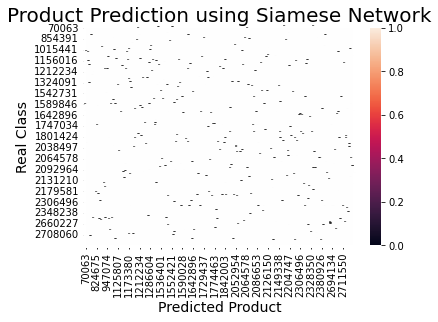

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_confusion, annot=True)

plt.title('Product Prediction using Siamese Network', fontsize=20)

plt.xlabel('Predicted Product', fontsize=14)

plt.ylabel('Real Class', fontsize=14)

plt.show()

In [ ]:
fp_tp_dict = dict()
confusion_matrix = dict()
for i in mid_categ_list:
    t_count = 0
    f_count = 0
    fp_tp_dict[i] = {'T':t_count, 'F':f_count}
    
    confusion_column = {i :[j for j in mid_categ_list]}
for i, row in df_photoReview_002_apn_sim_matrix.iloc[0:].iterrows():
    min_index = np.argsort(df_photoReview_002_apn_sim_matrix.iloc[i, 10:])[1]
#     print(df_photoReview_002_apn_sim_matrix.loc[min_index]["mid_category"])
#     print(df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"])
    if df_photoReview_002_apn_sim_matrix.loc[min_index]["mid_category"] == df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]:
        fp_tp_dict[df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]]['T'] += 1
        
    else: 
        fp_tp_dict[df_photoReview_002_apn_sim_matrix.iloc[i]["mid_category"]]['F'] += 1

filename width height xmin ymin  \
0    324416_0_gallery_60db0f3fda63b_jpg.rf.c122b1e0...   268    387    0    0   
1    324416_0_gallery_5f853b8b0c6cf_jpg.rf.2b9accc0...   299    219    0    0   
2    324416_0_gallery_5ea26b7970d44_jpg.rf.ec7dcbe5...   513    398    0    0   
3    324416_0_gallery_60e300731d5a3_jpg.rf.78c96a5d...   336    353    0    0   
4    324416_0_gallery_5ebe49650f317_jpg.rf.6521b54e...   488    608    0    0   
..                                                 ...   ...    ...  ...  ...   
259  2122566_0_gallery_624edccab0471_jpg.rf.b9a493c...   265    320    0    1   
260  2122566_0_gallery_625ff9c56c7b4_jpg.rf.7d29f51...   161    255    0    0   
261  2122566_0_gallery_620f9ac6e3190_jpg.rf.0f60507...   176    143    0    0   
262  2122566_0_gallery_62af3eee9692a_jpg.rf.08f5862...   300    339    0    0   
263  2122566_0_gallery_625ff9c626d39_jpg.rf.0e6bd8f...   175    164    0    0   

    xmax ymax goods_id mid_category  \
0    268  387   324416       001001   
1    299  219   324416       001001   
2    513  398   324416       001001   
3    336  353   324416       001001   
4    488  608   324416       001001   
..   ...  ...      ...          ...   
259  265  320  2122566       001001   
260  161  255  2122566       001001   
261  176  143  2122566       001001   
262  300  339  2122566       001001   
263  175  164  2122566       001001   

                                           goods_image  ...  \
0    https://image.msscdn.net/images/goods_img/2016...  ...   
1    https://image.msscdn.net/images/goods_img/2016...  ...   
2    https://image.msscdn.net/images/goods_img/2016...  ...   
3    https://image.msscdn.net/images/goods_img/2016...  ...   
4    https://image.msscdn.net/images/goods_img/2016...  ...   
..                                                 ...  ...   
259  https://image.msscdn.net/images/goods_img/2021...  ...   
260  https://image.msscdn.net/images/goods_img/2021...  ...   
261  https://image.msscdn.net/images/goods_img/2021...  ...   
262  https://image.msscdn.net/images/goods_img/2021...  ...   
263  https://image.msscdn.net/images/goods_img/2021...  ...   

    distance_/content/drive/Othercomputers/내 노트북/12sw_project.v4i.tensorflow/train/1886950_0_gallery_60c4db34d6a73_jpg.rf.02412814c2859dcd265abdc02253805d.jpg  \
0                                            0.8209603                                                                                                           
1                                            1.2305309                                                                                                           
2                                             0.731051                                                                                                           
3                                            1.4692386                                                                                                           
4                                           0.91926277                                                                                                           
..                                                 ...                                                                                                           
259                                          1.0217116                                                                                                           
260                                           0.969857                                                                                                           
261                                          0.6504293                                                                                                           
262                                          1.5961927                                                                                                           
263                                          2.0010593           